# Experiments on sub-dataset with no text instance

##### 7/20
Harnessed data from destroy-bg ablation on no_text_has_instance dataset, using naive iou semantic metric. 


In [1]:
CWD = %pwd
CWD = str(CWD)
import sys
import json
from six.moves import cPickle
import os
import statistics
from collections import defaultdict,Iterable

from IPython.core.display import HTML 
from IPython.core.display import Image, display, display_pretty

import numpy as np
from scipy import misc, polyfit, stats
import skimage.io as io
import matplotlib.pyplot as plt
import PIL
# from PIL import Image
%matplotlib inline  

import nltk.align.bleu_score as BLEU


In [2]:

COCO_PATH = os.path.join(CWD,'data','coco')
COCO_ANNO_PATH = os.path.join(COCO_PATH, 'annotations')
COCO_TEXT_PATH = os.path.join(CWD, 'coco-text')
sys.path.insert(0, COCO_TEXT_PATH)
import coco_text as ct
ct = ct.COCO_Text(os.path.join(COCO_PATH, 'COCO_Text.json'))
import ablation
sys.path.insert(0, os.path.join(CWD, 'coco', 'PythonAPI'))
from pycocotools.coco import COCO,mask

loading annotations into memory...
0:00:02.787049
creating index...
index created!
/Users/zhuyifan/Documents/2016 Summer Research/textmatters/coco-text
loading annotations into memory...
Done (t=20.27s)
creating index...
index created!


In [3]:
"""
Load Coco data
"""

# load the data from captions
with open(COCO_ANNO_PATH + '/captions_train2014.json') as f:
    coco_captions = json.load(f)
# print len(coco_captions)
# with open(COCO_ANNO_PATH + 'captions_val2014.json') as f:
#     coco_captions =  dict(coco_captions.items() + json.load(f).items())
# print len(coco_captions)

# build the reverse dictionary, from img_id to captions, img_infos, and annotations
img_captions = {}
for img_info in coco_captions['images']:
    mid = str(img_info['id'])
    if not mid in img_captions:
        img_captions[mid] = {}
    img_captions[mid]['image'] = img_info

for cap_info in coco_captions['annotations']:
    mid = str(cap_info['image_id'])
    if not 'annotation' in img_captions[mid]:
        img_captions[mid]['annotation'] = []
        img_captions[mid]['captions'] = []
    img_captions[mid]['annotation'].append(cap_info)


In [4]:
"""Helper functions"""
IN_FILE_NAME  = 'scores_no_rel_texts_blackout.pkl'
OUT_FILE_NAME = 'no_rel_texts_img_ids'
IN_DIR        = 'input'
OUT_DIR       = 'output'

def pre_process_vis(vis, scores, l):
    """Since with large batch size, vis.json might contain duplicates. This function will purge out the duplicates.
    l is the number of image ids used to generate vis. After filtering, vis should have length 2l."""
    surplus = len(vis)-2*l
    return vis[:-surplus], scores[:-(surplus/2)]

def get_stat(data):
    if len(data)==0: return;
    l = len(filter(lambda x:x!=1, data))
    print ""
    print "Total:\t%d;\t\tMean:\t\t%f;\tNone-ones:\t%d(%.02f%%)"%(len(data), statistics.mean(data), l, 100.*l/len(data))
    print "Median:\t%f;\tMedian(H):\t%f;\tMedian(L):\t%f;"%(statistics.median(data), statistics.median_high(data), statistics.median_low(data))
    print "Max:\t%f;\tMin:\t\t%f;\tStd:\t\t%f"%(max(data), min(data),statistics.stdev(data))
    print "\n"
    
def look_up_image(title, img_id, logs):
    print "[%s]%s\n"%(img_id,title)
    print "\tScore:%s;\n"%(logs[img_id]['score'])
    print "\tOriginal Caption:\n\t\t%s;\n\tAblation Caption:\n\t\t%s;"%(logs[img_id]['orig'], logs[img_id]['ablt'])
    print "\tAnnotated Captions:\n"
    for i, note in enumerate(img_captions[img_id]['annotation']):
        print "\t\t%d. %s\n"%(i+1, str(note['caption']).strip())
    
    ablt_meth = logs['ablation_method'] if 'ablation_method' in logs else 'blackout'
    print logs['ablation_method']
    [(_,orig_img_path , ablt_img_path)]  = ablation.ablate(imgIds = [int(img_id)], mode = ablt_meth, ct=ct, ksize=(7,7),sigma=5.,width=7)
    
    orig_img, ablt_img = io.imread(orig_img_path), io.imread(ablt_img_path)
    plt.figure(int(img_id), figsize=(15,30))
    plt.subplot(1,2,1)
    plt.imshow(orig_img)
    plt.subplot(1,2,2)
    plt.imshow(ablt_img)
    plt.show()
    return orig_img, ablt_img

def get_expr_summary(log_file='', in_path=IN_DIR, out_path=OUT_DIR, num=3):
    logs = cPickle.load(open(os.path.join(OUT_DIR, log_file)))
    scores = [(k,x['score']) for k, x in logs.iteritems() if isinstance(x,dict)]
    get_stat(map(lambda x: x[1], scores))

    sorted_scores_idx = sorted(scores, key=lambda x: -x[1])   # sort by score
    for idx, _ in sorted_scores_idx[:num]:
        look_up_image("Images with lowest scores:",idx, logs)

def compute_bleu(imgId, candidate, n = 4):
    """
    Computer the bleu score of [cap] using COCO annotations as instances
    """ 
    references = [note['caption'] for note in img_captions[str(imgId)]['annotation']]
    return BLEU.bleu(candidate, references, [1.0/n]*n)

In [6]:
# compute_bleu(515066,"an air plane is riding a person on a skateboard")

with open(os.path.join(OUT_DIR, 'no_text_has_instances.pkl')) as f:
    d = cPickle.load(f)

# add bleu score of the original caption to the dictionary
for k,x in d.iteritems():
    if not isinstance(x,dict):
        continue
    x['orig_bleu'] = compute_bleu(int(k), x['orig'])
    x['ablt_bleu'] = compute_bleu(int(k), x['ablt'])
    

In [7]:
# calculate object instance areas and add to results
coco = ablation.coco
def calc_area(imgId, img):
    """copied from ablation.destroy_bg"""
    annIds = coco.getAnnIds(imgIds=int(imgId))
    anns = coco.loadAnns(annIds)

    h, w = img['height'], img['width']
    segs, rles = [], []
    for ann in anns:
        if not ann['iscrowd']:
            segs += ann['segmentation']
        else:
            rles.append(ann['segmentation'])
    mk = None
    if len(segs)!=0:
        mk = mask.merge( mask.frPyObjects(segs, h,w), intersect = 0)
    if len(rles)!=0:
        mk2 = mask.merge( mask.frPyObjects(rles, h,w), intersect = 0)
        mk = mask.merge([mk,mk2], intersect = 0) if mk!=None else mk2
    area = mask.area([mk])
    return 1.0*area[0]/(h*w)

for k, x in d.iteritems():
    if not isinstance(x,dict):
        continue
    img = coco.loadImgs([int(k)])[0]
    x['area'] = calc_area(k, img)


In [8]:
#save to disk, because it has been a long journey
# with open('full_no_text_has_instance_dict.pkl','w+') as f:
#     cPickle.dump(d, f, protocol=cPickle.HIGHEST_PROTOCOL)

# with open('full_no_text_has_instance_dict.pkl') as f:
#     d=cPickle.load(f)
raw = [x['score'] for k, x in d.iteritems() if isinstance(x,dict)]
get_stat(raw)



Total:	82081;		Mean:		0.380484;	None-ones:	68238(83.13%)
Median:	0.250000;	Median(H):	0.250000;	Median(L):	0.250000;
Max:	1.000000;	Min:		0.000000;	Std:		0.344731




82081


/Users/zhuyifan/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


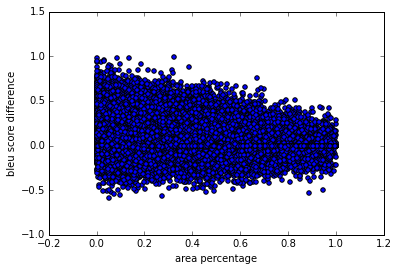

In [9]:
areas, scores = [], []
threshold = 0.9
for k,x in d.iteritems():
    if not isinstance(x,dict):
        continue
    areas.append(x['area'])
    scores.append(x['orig_bleu']- x['ablt_bleu'])
print len(areas)
# plt.figure(figsize=(8,10))
plt.scatter(areas, scores)
plt.ylabel('bleu score difference')
plt.xlabel('area percentage')
plt.show()

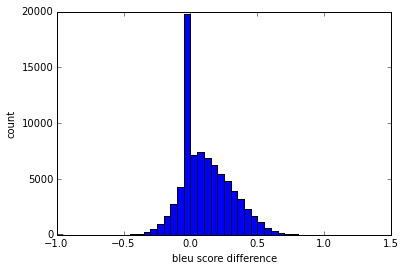


Total:	82081;		Mean:		0.113305;	None-ones:	82081(100.00%)
Median:	0.072560;	Median(H):	0.072560;	Median(L):	0.072560;
Max:	0.993355;	Min:		-0.591098;	Std:		0.181888




In [33]:
bin_width = 0.05
no_change = [x['orig_bleu']- x['ablt_bleu'] for _, x in d.iteritems() if isinstance(x,dict) and x['area'] < 0.5]
# print len(no_change), no_change
plt.hist(scores, bins=np.arange(-1.0, 1.0+bin_width, bin_width))
plt.ylabel('count')
plt.xlabel('bleu score difference')
plt.show()
get_stat(scores)

In [10]:
zero_areas = [ k for k,x in d.iteritems() if isinstance(x,dict) and x['area'] < 0.05 and x['score'] == 1]
print len(zero_areas)
#regression from scores against areas
m, b, r, p ,stderr = stats.linregress(scores, areas)
print m, b, r**2, p, stderr

310
-0.444891157684 0.346051061896 0.111061081575 0.0 0.00439331918286


In [25]:
#sort all images by bleu score differences
incr_perf = [(k,x['ablt_bleu'], x['orig_bleu']) for k,x in d.iteritems() if isinstance(x,dict)]
incr_perf.sort(key = lambda (x,y,z): y-z)
# incr_perf = [k for (k, _, _) in incr_perf]

#find all images with 0 jaccard score
zero_jac= [k for k,x in d.iteritems() if isinstance(x,dict) and x['score']==0 ]
print len(zero_jac)

13398


0.609440731262 0.35152027569
[32695]

	Score:0.0;

	Original Caption:
		a red fire hydrant sitting in the middle of a forest;
	Ablation Caption:
		a vase with a flower on top of it;
	Annotated Captions:

		1. A fire hydrant surrounded by leaves and vines.

		2. A fire hydrant beginning to get covered with trailing leaves from nearby trees.

		3. A fire hydrant with a vine on it in the shade

		4. A fire hydrant has some bushes next to it.

		5. A fire hydrant has many plants growing on it.

destroy
Ablating image 1/1 with id 32695 


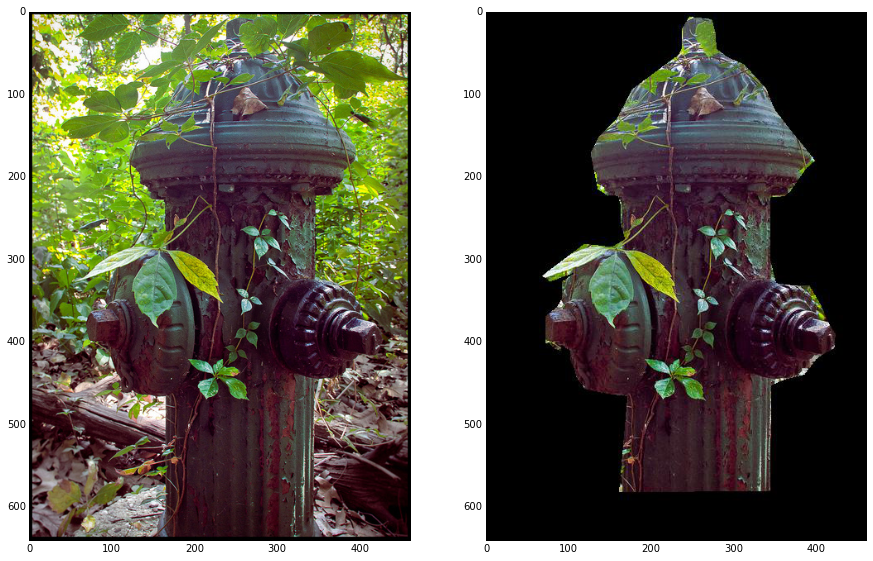

In [37]:
import random
iid = zero_jac[random.randint(0, len(zero_jac))]
# iid = incr_perf[iid][0]
print d[iid]['orig_bleu'], d[iid]['ablt_bleu']
_ = look_up_image("", iid, d)

In [119]:
compute_bleu(86,"You are stupid")

0